In [115]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

## Preliminary Data Management

In [116]:
yelp = pd.read_table('C://Users//fergu//sentiment_labelled_sentences//yelp_labelled.txt', header=None)

In [117]:
yelp.columns=['comment', 'score']

In [118]:
yelp.shape

(1000, 2)

In [119]:
yelp.head()

,comment,score
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## Select Words for Use In Classifier

The starting dataset chosen was the 'yelp' dataset. As expected, the words selected were adjectives that one would expect to see in a positive review, such as 'great', awesome', 'excellent', etc. A few of the words chosen, such as 'delicious' or 'friendly', would apply to service industries but not to movie or most product reviews. Some experimentation was done with the use of repeated exclamation marks, or question marks, but these were not found to be of much predictive value. Some words that were clearly not very useful were discarded although the final list of words was not rigorously vetted in this way.

In [120]:
words = ['great', 'happy', 'awesome', 'fabulous', 'value', 'sweet', 'fantastic', 'loved', 'good', 
         'fast', 'amazing', 'pleased', 'impressed', 'excellent', 'really good', 'delicious', 
         'nice', 'friendly', 'beautiful', 'brilliant']#, 'saved', 'love']

## Create Table of Boolean Columns and convert Score to Boolean

In [121]:
for word in words:
    yelp[word] = [True if word.lower() in yelp['comment'][j].lower() else False for j in range(0, len(yelp['comment']))]

In [122]:
yelp['score'] = [True if yelp['score'][i] == 1 else False for i in range(0, len(yelp['score']))]

In [123]:
yelp.head()

,comment,score,great,happy,awesome,fabulous,value,sweet,fantastic,loved,...,amazing,pleased,impressed,excellent,really good,delicious,nice,friendly,beautiful,brilliant
0,Wow... Loved this place.,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,Crust is not good.,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Not tasty and the texture was just nasty.,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Stopped by during the late May bank holiday of...,True,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,The selection on the menu was great and so wer...,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Heatmap of DataFrame Correlation Map

This shows that the variables are all only weakly correlated with one another, if at all. This demonstrates suitability for the Naive Bayes Classifier Model. 

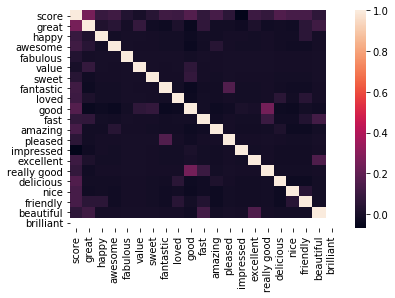

In [124]:
sns.heatmap(yelp.corr())
plt.show()

## Run The Model

In [125]:
data = yelp[words]
target = yelp['score']

In [126]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(data, target)
y_pred = bnb.predict(data)

In [127]:
print('Accurate predictions of this model configured for {} datapoints: {}'.format((len(yelp)), (target==y_pred).sum()))

Accurate predictions of this model configured for 1000 datapoints: 735


### Confusion Matrix

In [128]:
conf = np.array([[((target==True) & (y_pred==True)).sum(),((target==True) & (y_pred==False)).sum()],
                 [((target==False) & (y_pred==True)).sum(),((target==False) & (y_pred==False)).sum()]])
print(conf)


[[268 232]
 [ 33 467]]


### Sensitivity - defined as the percentage of positives correctly identified


In [129]:
# Here we are defining a positive as a FALSE result (since the model is determining whether an e-mail is GENUINE) so we will 
# use that in the calculation instead of 'True':

posco = ((target==True) & (y_pred==True)).sum()
posinco = ((target==True) & (y_pred==False)).sum()
negco = ((target==False) & (y_pred==False)).sum()
neginco = ((target==False) & (y_pred==True)).sum()


print('Sensitivity: \n', negco/(negco + neginco))

Sensitivity: 
 0.934


### Specificity - defined as the percentage of negatives correctly identified

In [130]:
# Defined as the converse of sensitivity- see notes above.

print('Specificity: \n', posco/(posco + posinco))

Specificity: 
 0.536


In [131]:
testdf = pd.DataFrame({'col1': [1,2,3,4,5], 'col2': [6,7,1,3,9], 'col3': [3,5,2,9,8], 'col4': [8,6,7,1,8], 'col1': [2,5,1,9,6]})
testdf

,col1,col2,col3,col4
0,2,6,3,8
1,5,7,5,6
2,1,1,2,7
3,9,3,9,1
4,6,9,8,8


In [132]:
x = 0
y = 1
testdf.iloc[x:y+2, :]

,col1,col2,col3,col4
0,2,6,3,8
1,5,7,5,6
2,1,1,2,7


In [143]:
folds = 10

size = int(len(yelp) / folds)

count = 0

accu_mat = []

i = 1
while i <= folds:

    data = yelp[words]
    target = yelp['score']
     
    train_set = data.drop([i for i in range(count, count+size)], axis=0)
    # 'iloc' notation works OK here:
    test_set = data.iloc[count:count+size-1,:]
        
    train_target = target.drop([i for i in range(count, count+size)], axis=0)
    
    # .....but not here:
    #test_target = target.iloc(axis=0)[count:count+size-1,:]
    # so code it this way instead:
    test_target = target[count:count+size-1]
        
    bnb.fit(train_set, train_target)
    y_pred = bnb.predict(test_set)
    
    accuracy = ((y_pred == test_target).sum()) / len(test_target)
    
    accu_mat.append(format(accuracy, '.4f'))
    
    count += size
    i += 1
    
print('Here is the accuracy array for this configuration: \n', accu_mat)


Here is the accuracy array for this configuration: 
 ['0.6566', '0.6970', '0.7172', '0.7172', '0.6970', '0.7475', '0.7273', '0.6970', '0.7677', '0.9192']


## Apply The Model To Other Datasets

The model gave a 69.5% accuracy for the Amazon data, which is almost as good as for the training dataset (73.5%). For the IMDB data, however, the accuracy drops to only 59.4%. If re-training the model for the IMDB data, one would want to add some words that better relate to a viewed experience, than a product. Examples of such words include: gripping, action-packed, touching, dramatic, fascinating, spellbinding.

In [16]:
other_data = ['amazon', 'imdb']

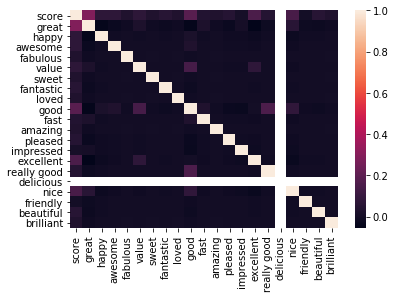

Accurate predictions of this model configured for the amazon data having 1000 datapoints: 695


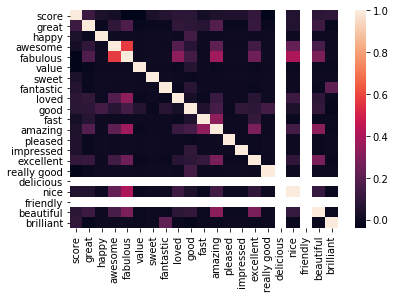

Accurate predictions of this model configured for the imdb data having 748 datapoints: 444


In [17]:
for i in range(0, len(other_data)):
    filename = other_data[i] +'.txt'
    #tablename = other_data[i] + '_data'
    path = 'C://Users//fergu//sentiment_labelled_sentences//' + filename
    df=pd.read_table(path, header=None)
    df.columns = ['comment', 'score']
    
    for word in words:
        df[word] = [True if word.lower() in df['comment'][j].lower() 
                           else False for j in range(0, len(df['comment']))]  
        
    df['score'] = [True if df['score'][i] == 1 else False for i 
                          in range(0, len(df['score']))]    
        
    sns.heatmap(df.corr())
    plt.show()
    
    data = df[words]
    target = df['score']
    
    bnb.fit(data, target)
    y_pred = bnb.predict(data)
    
    print('Accurate predictions of this model configured for the {} data having {} datapoints: {}'
          .format(other_data[i], (len(df)), (target==y_pred).sum()))
